In [242]:
import pandas as pd

In [243]:
df_results0 = pd.read_csv(r"../data/cohere_results", delimiter=",", on_bad_lines="skip")

In [244]:
df_results0.head()

,cohere_resp,index,label
0,56,0,false
1,15,1,partly true/misleading
2,85,2,partly true/misleading
3,85,3,true
4,I'm sorry but I was unable to find any relevan...,4,false


In [245]:
#remove other and complicated labels 
# df_results0 = df_results0[~df_results0['label'].isin(['complicated/hard to categorise', 'other'])]


In [246]:
df_results0.shape

(996, 3)

In [303]:
def simplify_truth(row):
    if row['label']=='true':
        return 1
    else: return 0
    # if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
    #     return 'false'
    # else:
    #     return 'true'
    

df_results0['simple_truth'] = df_results0.apply(simplify_truth, axis=1)

df_results0["simple_truth"].value_counts() #much more false than true

simple_truth
0    792
1    204
Name: count, dtype: int64

In [304]:
def cohere_tv(row):
    resp = row['cohere_resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50: #TODO: tune this value?
        return 1
    
    else:
        return 0
    

df_results0['cohere_simple'] = df_results0.apply(cohere_tv, axis=1)
# print(df_results0.shape)
df_processed = df_results0.copy().drop(df_results0[(df_results0.cohere_simple != 0) & (df_results0.cohere_simple != 1)].index)
df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index)
df_processed = df_processed.reset_index()

In [305]:
df_processed.head()

,level_0,cohere_resp,index,label,simple_truth,cohere_simple
0,0,56,0,false,0,1
1,1,15,1,partly true/misleading,0,0
2,2,85,2,partly true/misleading,0,1
3,3,85,3,true,1,1
4,5,85,5,mostly true,0,1


In [306]:
df_processed['simple_truth'].values.shape

(885,)

In [307]:
from sklearn.metrics import classification_report

### Overall Performance

In [308]:
print(classification_report(df_processed['simple_truth'].values.tolist(), df_processed['cohere_simple'].values.tolist()))

              precision    recall  f1-score   support

           0       0.83      0.32      0.47       699
           1       0.23      0.76      0.35       186

    accuracy                           0.42       885
   macro avg       0.53      0.54      0.41       885
weighted avg       0.71      0.42      0.44       885



In [255]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return True
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return False

In [256]:
def conservative_true(label):
    if label=="true":
        return 1
    else:
        return 0

In [257]:
df_x_fact = pd.read_csv("../data/x_fact_dataset/x-fact-including-en/train.all.tsv", delimiter="\t", on_bad_lines="skip")

In [258]:
df_processed['index'][0]

0

In [259]:
df_results0

,cohere_resp,index,label,simple_truth,cohere_simple
0,56,0,false,0,1
1,15,1,partly true/misleading,0,0
2,85,2,partly true/misleading,0,1
3,85,3,true,1,1
4,I'm sorry but I was unable to find any relevan...,4,false,0,unknown
...,...,...,...,...,...
991,85,995,partly true/misleading,0,1
992,95,996,partly true/misleading,0,1
993,95,997,false,0,1
994,"This statement is mostly true, albeit with som...",998,complicated/hard to categorise,0,unknown


In [260]:
df_processed

,level_0,cohere_resp,index,label,simple_truth,cohere_simple
0,0,56,0,false,0,1
1,1,15,1,partly true/misleading,0,0
2,2,85,2,partly true/misleading,0,1
3,3,85,3,true,1,1
4,5,85,5,mostly true,0,1
...,...,...,...,...,...,...
880,990,92,994,true,1,1
881,991,85,995,partly true/misleading,0,1
882,992,95,996,partly true/misleading,0,1
883,993,95,997,false,0,1


In [264]:
df_processed.iloc[389]

level_0           446
cohere_resp        95
index             447
label            true
simple_truth        1
cohere_simple       1
Name: 389, dtype: object

In [266]:
df_x_fact.iloc[447]

language                                                     ka
site                                               factcheck.ge
evidence_1    Oct 6, 2015 — ფოთში, მოზარდებისთვის ძალადობის ...
evidence_2    თინა ბოკუჩავა: ფოთში, მოზარდებისთვის ძალადობის...
evidence_3    Jul 12, 2019 — თინა ბოკუჩავა: ფოთში, მოზარდები...
evidence_4    ფილმის ჩვენება არასამთავრობო ... ფოთში ფილმის ...
evidence_5    ფოთში, მოზარდებისთვის ძალადობის შემცველი სცენე...
link_1        https://factcheck.ge/ka/story/19588-thina-boku...
link_2        https://fr-fr.facebook.com/Factcheck.ge/posts/...
link_3        https://hi-in.facebook.com/Factcheck.ge/posts/...
link_4        https://www.transparency.ge/ge/post/general-an...
link_5        http://142.93.167.204/ka/page/persons/thina-bo...
claimDate                                                  none
reviewDate                                                 none
claimant                                          თინა ბოკუჩავა
claim         ფოთში, მოზარდებისთვის ძალა

In [329]:
euro_y_true = []
euro_y_pred = []
non_euro_y_true = []
non_euro_y_pred = []
for i in range(df_processed.shape[0]):
    init_index = df_processed['index'][i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if euro_or_not(df_x_fact['language'][init_index]):
        euro_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        euro_y_pred.append(df_processed['cohere_simple'][i])
    else:
        non_euro_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        non_euro_y_pred.append(df_processed['cohere_simple'][i])

### Non-European vs European

In [330]:
print(classification_report(euro_y_true, euro_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.27      0.40       360
           1       0.29      0.79      0.43       136

    accuracy                           0.41       496
   macro avg       0.53      0.53      0.41       496
weighted avg       0.64      0.41      0.40       496



In [331]:
print(classification_report(non_euro_y_true, non_euro_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.39      0.54       339
           1       0.14      0.66      0.23        50

    accuracy                           0.42       389
   macro avg       0.51      0.52      0.38       389
weighted avg       0.79      0.42      0.50       389



### Western vs Non-Western

In [312]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return True
    else:
        return False

In [323]:
western_y_true = []
western_y_pred = []
non_western_y_true = []
non_western_y_pred = []
for i in range(df_processed.shape[0]):
    init_index = df_processed['index'].values[i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if western(df_x_fact['language'][init_index]):
        western_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        western_y_pred.append(df_processed['cohere_simple'][i])
    else:
        non_western_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        non_western_y_pred.append(df_processed['cohere_simple'][i])

In [324]:
print(classification_report(western_y_true, western_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.30      0.44       286
           1       0.25      0.74      0.38        90

    accuracy                           0.41       376
   macro avg       0.52      0.52      0.41       376
weighted avg       0.66      0.41      0.42       376



In [325]:
print(classification_report(non_western_y_true, non_western_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.34      0.49       413
           1       0.21      0.77      0.33        96

    accuracy                           0.42       509
   macro avg       0.54      0.55      0.41       509
weighted avg       0.74      0.42      0.46       509



### Small vs Large

In [287]:
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return True
    else: return False

In [320]:
small_y_true = []
small_y_pred = []
large_y_true = []
large_y_pred = []
for i in range(df_processed.shape[0]):
    # if df_results0['cohere_simple'][i] not in [0,1]:
    #     continue
    init_index = df_processed['index'].values[i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if small(df_x_fact['language'][init_index]):
        small_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        small_y_pred.append(df_processed['cohere_simple'][i])
    else:
        large_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        large_y_pred.append(df_processed['cohere_simple'][i])

In [321]:
print(classification_report(small_y_true, small_y_pred))

              precision    recall  f1-score   support

           0       0.73      0.13      0.22       126
           1       0.35      0.91      0.50        64

    accuracy                           0.39       190
   macro avg       0.54      0.52      0.36       190
weighted avg       0.60      0.39      0.31       190



In [322]:
print(classification_report(large_y_true, large_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.37      0.51       573
           1       0.19      0.68      0.29       122

    accuracy                           0.42       695
   macro avg       0.52      0.52      0.40       695
weighted avg       0.73      0.42      0.47       695



In [345]:
for i in df_processed['cohere_resp'].values:
    if float(i)<30:
        print(i)

15
25
8
25
19
22
10
16
16
10
20
16
15
25
0
10
15
25
16
15
16
20
8
8
12
15
10
16
16
25
22
10
10
8
25
25
22
12
0
15
16
12
0
15
25
28
25
15
23
16
25
0
0
8
8
12
12
15
16
12
25
15
15
15
16
10
10
15
10
0
15
23
25
0
15
15
23
12
25
15
16
15
25
12
12
16
16
15
25
10
12
15
16
16
12
25
15
25
8
8
12
12
28
15
15
15
10
12
12
15
0
12
15
12
10
8
16
16
25
22.5
15
12
8
15
10
25
25
25
25
15
10
16
16
15
8
0
25
25
15
8
22
15
12
10
15
10
16
25
25
15
25
10
15
10
10
16
1
25
15
25
0
25
16
8
15
25
12
13
12
15
10
25
10
25
25
0
16
15
25
16
25
15
25
16
15
23
10
25
22.3
22
15
15
15
25
10
25
22
25
25
15
12
25
10
10
23
16
10
20
12
12
15
25
15
12
25
8


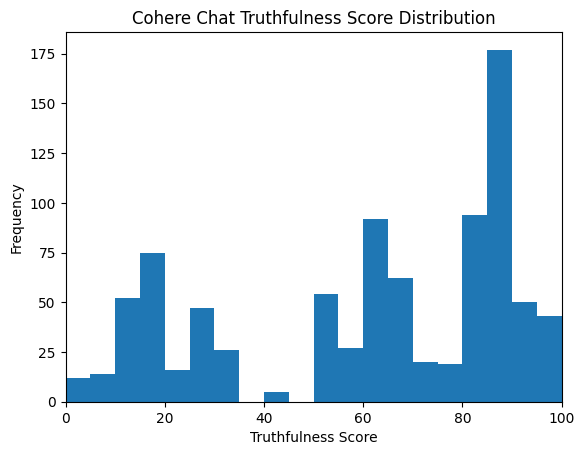

In [356]:
import matplotlib.pyplot as plt
plt.hist(df_processed['cohere_resp'].map(float).values,bins=20)
plt.xlim(0,100)
plt.title("Cohere Chat Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
plt.xlabel("Truthfulness Score")
plt.show()